HMMs Library 
============================
#### (Discrete & Continuous hidden markov models )

The document contain the tutorial ( usage explained by example ) for the hidden markov models library [link to pip].
* [The **first** part](#dthmm) will cover disrete-time hidden markov model (**DtHMM**)
* [The **second** part](#cthmm) will be dedicated to continuous-time hidden markov model (**CtHMM**)
* [The **third** part](#conv) will compare the convergences of **both** models

The all of the part are independent, so you do not need to run all notebook, if you are interested only in one of them. 


If you are not familiar with the hidden markov model theory, We recommend ...
%todo: refer to DP theory, (simple guide to cthmm?), github, sources


<a id='dthmm'></a>
Part 1: Discrete Time Hidden Markov Model
---------------------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

### Construct DtHMM 
You can directly initialize the DtHMM by passing the **model parameters**.  

We will create simple DtHMM of two hidden states and three output variables.

In [2]:
# A is the matrix of transition probabilities from state [row] to state [column].
A = np.array([[0.9,0.1],[0.4,0.6]])
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
B = np.array([[0.9,0.08,0.02],[0.2,0.5,0.3]])
# Pi is the vector of initial state probabilities.   
Pi = np.array( [0.8,0.2] )

# Create DtHMM by given parameters.
dhmm = hmms.DtHMM(A,B,Pi)

Or you can initialize it by **random parameters**. Passing the number of hidden states and output variables. 

In [3]:
dhmm_random = hmms.DtHMM.random(2,3)

### Save & Read from File
Once you have created the model you can **save** its parameters in file simply by calling *save_params* method.  

In [4]:
dhmm.save_params("Models/hello_dthmm") 

The method stored the parameters in *.npz* format.  

The saved file can be later used to **read** parametrs for model initialization.

In [5]:
dhmm_from_file = hmms.DtHMM.from_file( "Models/hello_dthmm.npz" )

### Set & Get Parameters
Later you can always **set** parameters with triple of methods corresponding to the constructors.

In [6]:
dhmm.set_params(A,B,Pi)
dhmm.set_params_random(2,3)
dhmm.set_params_from_file( "Models/hello_dthmm.npz" )

You can **get** parameters by calling them separately,

In [7]:
dhmm.a, dhmm.b, dhmm.pi

(array([[ 0.9,  0.1],
        [ 0.4,  0.6]]), array([[ 0.9 ,  0.08,  0.02],
        [ 0.2 ,  0.5 ,  0.3 ]]), array([ 0.8,  0.2]))

or **get** them **all** together as the triple.

In [8]:
(A,B,Pi) = dhmm.params

### Generate Random State and Emission Sequence
 Now we can use our model to generate state and emission sequence.   
 The model will randomly choose which transition or emission will happen, taking into consideration the parameters we have previously defined.


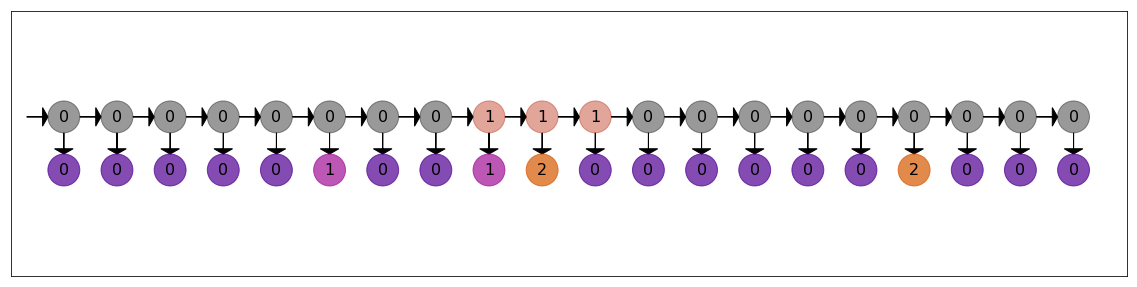

In [9]:
seq_len = 20
s_seq, e_seq = dhmm.generate( seq_len )

#resize plot
plt.rcParams['figure.figsize'] = [20,20]

hmms.plot_hmm( s_seq, e_seq )

### Find Most Likely State Sequence
If we have the model parameters and emission sequence, we can find the most probable state sequence that would generate it. Notice, that it can be different, than the actual sequence that has generated the emissions.  
We will use Viterbi algorithm for the calculation.


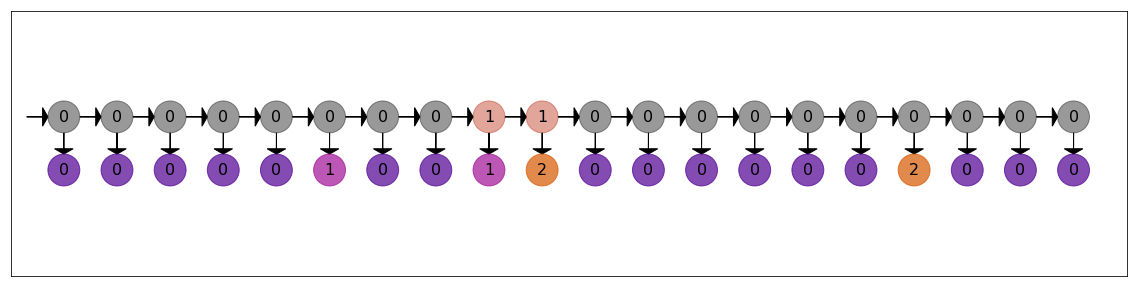

In [10]:
( log_prob, s_seq ) =  dhmm.viterbi( e_seq )
# Let's print the most likely state sequence, it can be same or differ from the sequence above.
hmms.plot_hmm( s_seq, e_seq )

The *prob* parameter store the probability of the sequence.  
All the probabilities in the library are stored in the logarithm of their actual value. As the number of possible sequences grows exponentialy by it length, it could easily lead to float underflow.  
You can easily transform it to the normal scale value applying *exp* function. 

In [11]:
np.exp( log_prob )

1.5822415043907773e-07

### The Probability of the Emission Sequence
We can compute the probabilityoft the model generating the emission sequence.

In [12]:
np.exp( dhmm.emission_estimate( e_seq ) )

1.1839976408168135e-06

### Generate Artificial Dataset

You can easily generate many sequences in once by using the generate_data function.
The generated emission sequences are in the form that is suitable for training of parameters. You can switch times=True, if you want to generate also the corresponding equidistant time sequences.

In [13]:
seq_num= 3   #number of data sequences
seq_len= 10  #length of each sequence

dhmm.generate_data( (seq_num,seq_len) )

(array([[0, 0, 1, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 1]]),
 array([[0, 0, 1, 0, 1, 2, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 2, 0, 0, 0, 0],
        [0, 0, 0, 2, 0, 0, 0, 0, 0, 1]]))

### Parameters Estimation - Baum Welch Algorithm
We usually do not know the real parameters of the model. But, if we have sufficient data, we can estimate them by EM algorithm.  
Here we will have several output variables (emissions) sequences and we will show, how to use them to train the model parameters

Let's start by creating some artifficial data. We will use the previously defined *dhmm* model for it.


In [14]:
seq_num = 5
seq_len = 50
data = np.empty( (seq_num, seq_len), dtype=int )

_ , data = dhmm.generate_data( (seq_num,seq_len) )

data

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0],
       [1, 0, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0],
       [1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 1, 2, 1, 2, 0]])

Now, we will create the model with random parameters, that will be eventually trained to much the data.

In [15]:
dhmm_r = hmms.DtHMM.random( 2,3 )
# We can print all the parameters.
hmms.print_parameters( dhmm_r )

Initial probabilities (π) :


,0
0,0.487431
1,0.512569


Transition probabilities matrix (A):


,0,1
0,0.225174,0.774826
1,0.440121,0.559879


Emission probabilities matrix (B):


,0,1,2
0,0.481975,0.006696,0.511330
1,0.489328,0.065943,0.444729


Let's compare the dataset likelihood estimation of model used for generating the data and the random parameters model. 

In [16]:
print( "Generator model:" , np.exp( dhmm.data_estimate(data)   ) )
print( "Random model:   " ,np.exp( dhmm_r.data_estimate(data) ) )

Generator model: 5.92028078546e-70
Random model:    1.56696982137e-125


Most likely the probability that the data was generated by random model is extremly low.

Now we can take the random model and reestimate it to fit the data better.

In [17]:
dhmm_r.baum_welch( data, 10 )
print( "Reestimated model after 10 iterations:   " ,np.exp( dhmm_r.data_estimate(data) ) )

Reestimated model after 10 iterations:    4.29626311587e-73


The probability of the reestimated model should now be similiar (possibly even higher) that the generator's model. If it is not, you can try to run the estimation procedure more time at different randomly generated models. It could happen that the estimation fall in the local optima.

If you are satisfied with the results, you can run some more iteration to fine-tune it.

In [18]:
dhmm_r.baum_welch( data, 100 )
print( "Reestimated model after 110 iterations:   " ,np.exp( dhmm_r.data_estimate(data) ) )

Reestimated model after 110 iterations:    1.32552480235e-72


We can compare the parameters of the model.

In [19]:
hmms.print_parameters( dhmm_r )
hmms.print_parameters( dhmm )

Initial probabilities (π) :


,0
0,3.587002e-32
1,1.000000e+00


Transition probabilities matrix (A):


,0,1
0,0.566020,0.433980
1,0.528711,0.471289


Emission probabilities matrix (B):


,0,1,2
0,0.894397,0.001844,0.103759
1,0.620972,0.378582,0.000446


Initial probabilities (π) :


,0
0,0.8
1,0.2


Transition probabilities matrix (A):


,0,1
0,0.9,0.1
1,0.4,0.6


Emission probabilities matrix (B):


,0,1,2
0,0.9,0.08,0.02
1,0.2,0.50,0.30


Alternatively, we can run *baum_welch_graph* method to get learning curve of estimated probabilities.

In [20]:
dhmm_r = hmms.DtHMM.random(2,3) 
out = dhmm_r.baum_welch_graph( data, 50 )

np.exp(out)

array([  1.86483957e-108,   8.66892470e-074,   1.20591400e-073,
         1.51720118e-073,   1.82126310e-073,   2.14351791e-073,
         2.50770940e-073,   2.93337549e-073,   3.43433349e-073,
         4.01722623e-073,   4.68201643e-073,   5.42311849e-073,
         6.23245389e-073,   7.10336402e-073,   8.03284739e-073,
         9.02496059e-073,   1.00920654e-072,   1.12579971e-072,
         1.25622699e-072,   1.40664991e-072,   1.58659072e-072,
         1.81150116e-072,   2.10725411e-072,   2.52059099e-072,
         3.14315489e-072,   4.17609336e-072,   6.12439674e-072,
         1.04686236e-071,   2.22515323e-071,   5.95345605e-071,
         1.72003677e-070,   4.08574363e-070,   7.07430500e-070,
         9.89374921e-070,   1.30080650e-069,   1.74102340e-069,
         2.32680691e-069,   2.93745744e-069,   3.48012961e-069,
         3.97382636e-069,   4.45557049e-069,   4.93917202e-069,
         5.42461924e-069,   5.90717697e-069,   6.38133626e-069,
         6.84137077e-069,   7.28282352e-

Let's plot it in the graph, comparing the results in ratio with *real* data-generator model. ( Notice, it is the ratio of logaritmic probability values. )

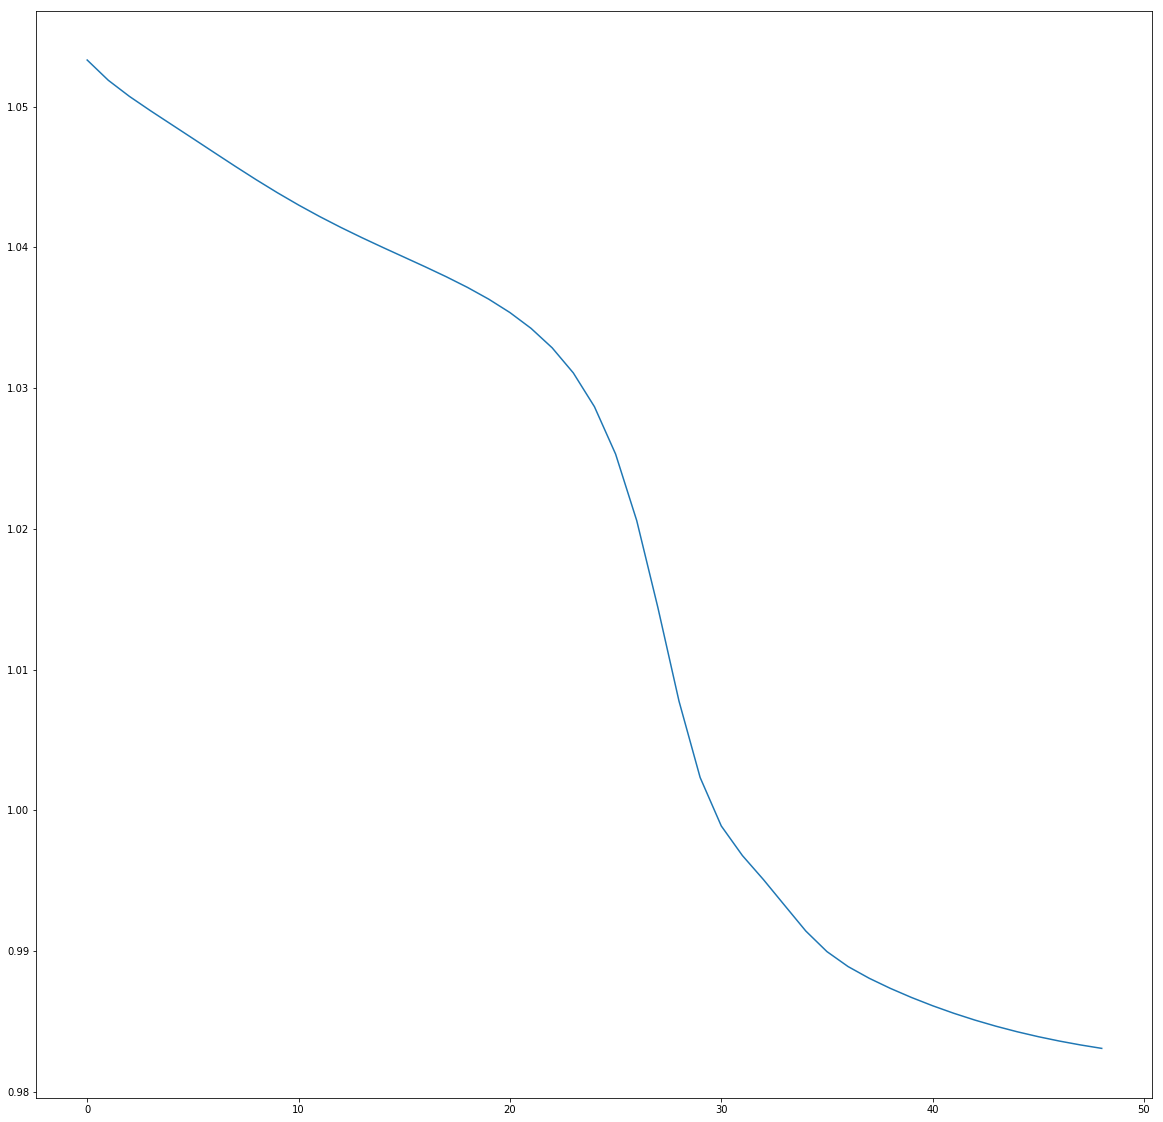

In [21]:
real = dhmm.data_estimate(data)
#For better visibility of the graph, we cut first two values.
plt.plot( out[2:] / real  )
plt.show()

<a id='cthmm'></a>
Part 2: Continuous Time Hidden Markov Model
-----------------------------------------------------

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

### Construct CtHMM 
Construction of CtHMM is similar to the discrete model. 

You can directly initialize the CtHMM by passing the **model parameters**.  
We will create simple CtHMM of three hidden states and three output variables.

In [23]:
# Q is the matrix of transition rates from state [row] to state [column].
Q = np.array( [[-0.375,0.125,0.25],[0.25,-0.5,0.25],[0.25,0.125,-0.375]] )
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
B = np.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
# Pi is the vector of initial state probabilities.   
Pi = np.array( [0.6,0,0.4] )

# Create CtHMM by given parameters.
chmm = hmms.CtHMM(Q,B,Pi)

Or you can initialize it by **random parameters**. Passing the number of hidden states and output variables. 

In [24]:
chmm_random = hmms.CtHMM.random(3,3)

### Save & Read from File

Once you have created the model you can save its parameters in file simply by calling save_params method.

In [25]:
chmm.save_params("Models/hello_cthmm") 

The method stored the parameters in .npz format.
The saved file can be later used to read parametrs for model initialization.

In [26]:
chmm_from_file = hmms.CtHMM.from_file( "Models/hello_cthmm.npz" )

### Set & Get Parameters
Later you can always set parameters with triple of methods corresponding to the constructors.

In [27]:
chmm.set_params(Q,B,Pi)
chmm.set_params_random(3,3)
chmm.set_params_from_file( "Models/hello_cthmm.npz" )

You can **get** parameters by calling them separately,

In [28]:
chmm.q, chmm.b, chmm.pi

(array([[-0.375,  0.125,  0.25 ],
        [ 0.25 , -0.5  ,  0.25 ],
        [ 0.25 ,  0.125, -0.375]]), array([[ 0.8 ,  0.05,  0.15],
        [ 0.05,  0.9 ,  0.05],
        [ 0.2 ,  0.05,  0.75]]), array([ 0.6,  0. ,  0.4]))

or get them all together as the triple.

In [29]:
(A,B,Pi) = chmm.params

### Generate Random Sequence
Now we can use our model to **generate** time, state and emission sequence.
The model will **randomly** choose which transition or emission will happen, taking into consideration the parameters we have previously defined.

The times are generated with **exponencial** waiting times, you can define the parameter of exponencial distribution as second optional parameter. 


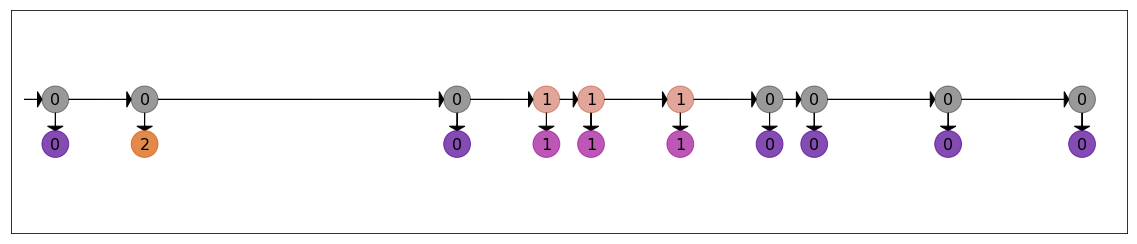

In [30]:
seq_len = 10
t_seq, s_seq, e_seq = chmm.generate( seq_len, 0.5 )

#resize plot
plt.rcParams['figure.figsize'] = [20,20]

hmms.plot_hmm( s_seq, e_seq, time=t_seq )

### Generate Artificial  Dataset
You can easily generate many sequences in once by using the *generate_data* function.  
The generated data are in the form that is suitable for training of parameters. 
You can switch *states=True*, if you want to generate also the corresponding state sequences.

TODO: The times are generated with **exponencial** waiting times, you can define the parameter of exponencial distribution as second optional parameter. 

In [31]:
seq_num= 5   #number of data sequences
seq_len= 30  #length of each sequence

t,e = chmm.generate_data( (seq_num,seq_len) )
t,e

(array([[ 0,  2,  4,  5,  6,  7,  8, 13, 14, 15, 19, 33, 41, 42, 43, 45, 50,
         51, 52, 58, 64, 70, 71, 73, 75, 77, 79, 80, 82, 83],
        [ 0,  1,  4,  9, 11, 14, 16, 19, 28, 30, 34, 36, 44, 45, 46, 52, 56,
         57, 59, 61, 63, 65, 72, 74, 75, 82, 83, 86, 95, 97],
        [ 0,  3,  5,  9, 13, 15, 16, 17, 20, 21, 28, 30, 33, 34, 35, 37, 41,
         42, 43, 45, 48, 51, 56, 58, 62, 65, 67, 70, 71, 72],
        [ 0,  1,  5,  8, 10, 11, 14, 16, 17, 21, 23, 26, 27, 30, 31, 33, 34,
         35, 39, 41, 42, 43, 47, 50, 53, 54, 55, 60, 61, 65],
        [ 0,  8,  9, 10, 13, 14, 16, 17, 18, 21, 22, 25, 26, 28, 30, 31, 32,
         34, 35, 39, 41, 45, 48, 50, 52, 54, 55, 58, 59, 63]]),
 array([[2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 0,
         1, 1, 0, 2, 1, 1, 1, 2],
        [0, 0, 2, 0, 1, 0, 1, 2, 0, 1, 2, 1, 0, 1, 2, 0, 2, 2, 2, 2, 0, 0,
         2, 0, 2, 2, 2, 1, 1, 0],
        [2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0,
         1

### Parameters Estimation - Continuous Version of Baum Welch Algorithm

We will use the previously generated data for the training of randomly generated model.

In [32]:
chmm_r = hmms.CtHMM.random( 3,3 )
# We can print all the parameters.
hmms.print_parameters( chmm_r )

Initial probabilities (π) :


,0
0,0.217989
1,0.431969
2,0.350042


Transition rate matrix (Q):


,0,1,2
0,-1.000000,0.643831,0.356169
1,0.642132,-1.000000,0.357868
2,0.991635,0.008365,-1.000000


Transition probabilities for one time unit :


,0,1,2
0,0.533439,0.271405,0.195156
1,0.339935,0.464528,0.195536
2,0.418175,0.129150,0.452675


Emission probabilities matrix (B):


,0,1,2
0,0.203888,0.223744,0.572368
1,0.328629,0.366821,0.304550
2,0.063882,0.410970,0.525148


Now we can compare the probabilities, that the data was generated by the given model. Its ratio is most probably not so big as in the disrete model. It is because the intervals between the observations are the source of many unknown, so it is pushing the probability of real model down. 

In [33]:
print( "Generator model:" , np.exp( chmm.data_estimate(t,e)   ) )
print( "Random model:   " ,np.exp( chmm_r.data_estimate(t,e) ) )

Generator model: 7.85828538368e-69
Random model:    4.39631991872e-72


Let's run the EM algorithm for couple of iterations.

In [34]:
out = chmm_r.baum_welch_graph( t,e, 100 )

np.exp(out)

array([  4.39631992e-72,   1.54479818e-70,   1.82714605e-70,
         2.17429704e-70,   2.62843186e-70,   3.23381582e-70,
         4.05574241e-70,   5.19267950e-70,   6.79478553e-70,
         9.09398871e-70,   1.24529797e-69,   1.74479985e-69,
         2.50110344e-69,   3.66779362e-69,   5.50307062e-69,
         8.44448553e-69,   1.32344586e-68,   2.11173257e-68,
         3.41343149e-68,   5.55451320e-68,   9.04079965e-68,
         1.46362030e-67,   2.34765436e-67,   3.72314152e-67,
         5.83537859e-67,   9.04408120e-67,   1.38760640e-66,
         2.10946426e-66,   3.17892943e-66,   4.74751704e-66,
         7.01937371e-66,   1.02577961e-65,   1.47844738e-65,
         2.09671737e-65,   2.91941097e-65,   3.98312258e-65,
         5.31719269e-65,   6.93916066e-65,   8.85124839e-65,
         1.10387766e-64,   1.34716462e-64,   1.61079573e-64,
         1.88986062e-64,   2.17916958e-64,   2.47373500e-64,
         2.76909935e-64,   3.06142098e-64,   3.34777412e-64,
         3.62588773e-64,

We will plot its probabilities estimations in ratio with generator model. (Notice, it is the ratio of logarithms of probabilities)

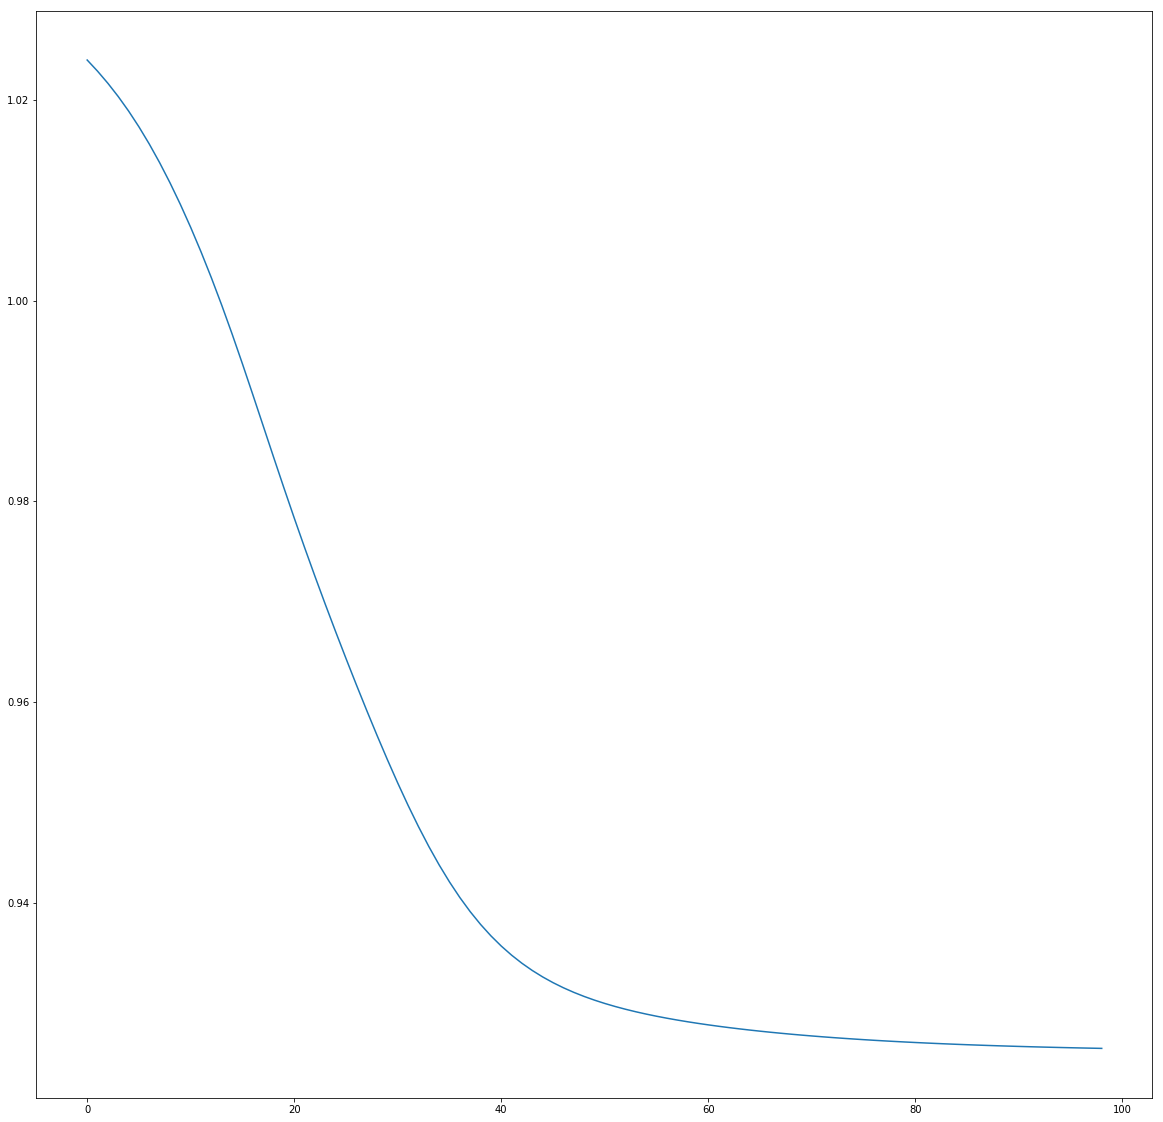

In [35]:
real = chmm.data_estimate( t, e )
#For better visibility of the graph, we cut first two values.
plt.plot( out[2:] / real  )

plt.show()

<a id='conv'></a>
Part 3: Comparison of Models Convergences
-----------------------------------------------------

In this chapter we will compare the convergence rate of discrete and continuous models. It will show some functions usefull for convergence among model parameters.  

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

We will start by defining the continuous time model. For that, who have read the previous section, it will be the familiar.

In [37]:
Q = np.array( [[-0.375,0.125,0.25],[0.25,-0.5,0.25],[0.25,0.125,-0.375]] )
B = np.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
Pi = np.array( [0.6,0,0.4] )

chmm = hmms.CtHMM( Q,B,Pi )
hmms.print_parameters( chmm )

Initial probabilities (π) :


,0
0,0.6
1,0.0
2,0.4


Transition rate matrix (Q):


,0,1,2
0,-0.375,0.125,0.250
1,0.250,-0.500,0.250
2,0.250,0.125,-0.375


Transition probabilities for one time unit :


,0,1,2
0,0.721157,0.092948,0.185895
1,0.185895,0.628209,0.185895
2,0.185895,0.092948,0.721157


Emission probabilities matrix (B):


,0,1,2
0,0.80,0.05,0.15
1,0.05,0.90,0.05
2,0.20,0.05,0.75


We can simply create discrete model with equivalent parameters, using function *get_dthmm_params*.  
By default, it will create the model with transition probabilities equal to one time unit probability transition in continuous model. You can pass the optional parameter for different time steps.


In [38]:
dhmm = hmms.DtHMM( *chmm.get_dthmm_params() )
hmms.print_parameters( dhmm )

Initial probabilities (π) :


,0
0,0.6
1,0.0
2,0.4


Transition probabilities matrix (A):


,0,1,2
0,0.721157,0.092948,0.185895
1,0.185895,0.628209,0.185895
2,0.185895,0.092948,0.721157


Emission probabilities matrix (B):


,0,1,2
0,0.80,0.05,0.15
1,0.05,0.90,0.05
2,0.20,0.05,0.75


We can let the disrete model to generate the data sufficient for both models by passing the *times* parameter as *True*.

In [39]:
t,_,e = dhmm.generate_data( (50,50), times=True )   
# The free space in the return triple is for the state sequences, we do not need them for the training 

We can compare the estimation of the data, using both of the model. (They should be the same.)

In [40]:
creal = chmm.data_estimate(t,e)
dreal = dhmm.data_estimate(e)
print("Data estimation by continuous model:", creal)
print("Data estimation by discrete model:  ", dreal)

Data estimation by continuous model: -2406.437744140625
Data estimation by discrete model:   -2406.437744140625


Now we will create two equivalent random models. 

In [41]:
ct = hmms.CtHMM.random(3,3)
dt = hmms.DtHMM( *ct.get_dthmm_params() )
    
hmms.print_parameters( ct )
hmms.print_parameters( dt )

Initial probabilities (π) :


,0
0,0.826497
1,0.020565
2,0.152938


Transition rate matrix (Q):


,0,1,2
0,-1.000000,0.488117,0.511883
1,0.941786,-1.000000,0.058214
2,0.146352,0.853648,-1.000000


Transition probabilities for one time unit :


,0,1,2
0,0.498133,0.285753,0.216114
1,0.389110,0.493231,0.117659
2,0.216486,0.365080,0.418434


Emission probabilities matrix (B):


,0,1,2
0,0.249766,0.401267,0.348967
1,0.114444,0.563583,0.321973
2,0.160617,0.319921,0.519461


Initial probabilities (π) :


,0
0,0.826497
1,0.020565
2,0.152938


Transition probabilities matrix (A):


,0,1,2
0,0.498133,0.285753,0.216114
1,0.389110,0.493231,0.117659
2,0.216486,0.365080,0.418434


Emission probabilities matrix (B):


,0,1,2
0,0.249766,0.401267,0.348967
1,0.114444,0.563583,0.321973
2,0.160617,0.319921,0.519461


We will train them at our dataset. (It can take a while.)

In [42]:
iter_num = 50
outd = dt.baum_welch_graph( e, iter_num )
outc = ct.baum_welch_graph( t,e, iter_num )
outd,outc

(array([-3163.96655273, -2603.32617188, -2597.24609375, -2587.56445312,
        -2571.99023438, -2547.92700195, -2514.99414062, -2478.57006836,
        -2448.11865234, -2428.83105469, -2418.56860352, -2413.22021484,
        -2410.21020508, -2408.33227539, -2407.04223633, -2406.08227539,
        -2405.32666016, -2404.70654297, -2404.18701172, -2403.74267578,
        -2403.36035156, -2403.02685547, -2402.73681641, -2402.48291016,
        -2402.25927734, -2402.06274414, -2401.88916016, -2401.73608398,
        -2401.60083008, -2401.48120117, -2401.37451172, -2401.28051758,
        -2401.19702148, -2401.12207031, -2401.0559082 , -2400.99707031,
        -2400.94360352, -2400.89575195, -2400.85400391, -2400.81542969,
        -2400.78125   , -2400.75048828, -2400.72216797, -2400.69677734,
        -2400.67382812, -2400.65234375, -2400.63330078, -2400.61547852,
        -2400.60009766, -2400.58520508, -2400.5715332 ]),
 array([-3163.96655273, -2604.10888672, -2599.90869141, -2594.45043945,
      

We can plot and compare both convergence rates. From the essence of models, the continuous model will probably  converge a bit slower, but finally will reach the similar value.

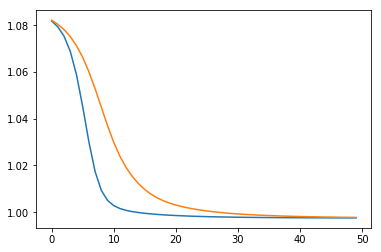

In [43]:
plt.plot( outd[1:] / dreal  )
plt.plot( outc[1:] / dreal  )
#plt.savefig('my_plot.svg')  #Optional save the figure
plt.show()

<hr/>
You can play with the models as you like and feel free to share your result with me, if you have made some interesting experiment!

Contact: (lopatovsky@gmail.com)

### Experimental features
#### Fast Convergence

In [44]:
seq_num= 5   #number of data sequences
seq_len= 30  #length of each sequence

t,e = chmm.generate_data( (seq_num,seq_len) )
t,e

(array([[ 0,  1,  2,  5,  7,  8, 11, 12, 15, 16, 17, 18, 23, 24, 25, 28, 30,
         31, 32, 33, 42, 47, 48, 49, 55, 56, 61, 64, 68, 70],
        [ 0,  2,  3,  5,  8, 14, 16, 17, 18, 20, 23, 24, 32, 33, 34, 37, 40,
         43, 50, 58, 63, 68, 73, 75, 78, 82, 86, 87, 92, 97],
        [ 0,  2,  4,  7,  9, 10, 13, 14, 15, 16, 18, 20, 22, 31, 33, 35, 36,
         37, 39, 40, 42, 43, 45, 46, 47, 50, 51, 52, 55, 59],
        [ 0,  2, 10, 13, 17, 18, 19, 22, 23, 24, 26, 27, 28, 30, 32, 35, 36,
         37, 39, 40, 43, 44, 45, 47, 50, 51, 53, 55, 56, 58],
        [ 0,  3,  4,  8, 12, 13, 14, 24, 25, 27, 28, 34, 39, 40, 41, 43, 45,
         51, 54, 58, 59, 68, 73, 75, 76, 77, 78, 79, 80, 82]]),
 array([[2, 1, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 1, 1, 2, 0, 0, 0,
         2, 0, 0, 2, 2, 2, 2, 2],
        [0, 0, 1, 1, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0,
         0, 2, 0, 0, 1, 1, 2, 0],
        [0, 0, 0, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2, 1, 0, 0, 2, 0,
         0

In [45]:
ct1 = hmms.CtHMM.random(3,3)
ct2 = hmms.CtHMM( *ct1.params )

In [46]:
iter_num = 20
out1 = ct1.baum_welch_graph( t,e, iter_num )
out2 = ct2.baum_welch_graph2( t,e, iter_num )
out1,out2

(array([-168.41700745, -156.10179138, -155.78437805, -155.63241577,
        -155.48513794, -155.33778381, -155.18902588, -155.03756714,
        -154.88232422, -154.72253418, -154.55778503, -154.3881073 ,
        -154.21382141, -154.03556824, -153.85417175, -153.67068481,
        -153.48623657, -153.30209351, -153.11953735, -152.93986511,
        -152.76434326]),
 array([-168.41700745, -156.01750183, -155.73823547, -155.53729248,
        -155.33224487, -155.11868286, -154.8939209 , -154.65582275,
        -154.40332031, -154.13710022, -153.85978699, -153.57592773,
        -153.29138184, -153.01269531, -152.74632263, -152.4979248 ,
        -152.27180481, -152.07046509, -151.89460754, -151.74328613,
        -151.61431885]))

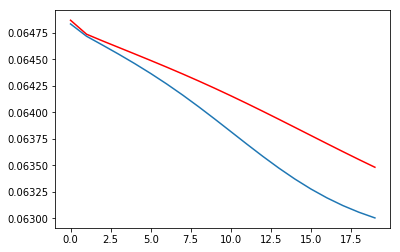

In [47]:
plt.plot( out1[1:] / dreal , color = "red" )
plt.plot( out2[1:] / dreal  )
#plt.savefig('graph.svg')  #Optional save the figure

plt.show()

In [48]:
hmms.print_parameters(ct1)
hmms.print_parameters(ct2)

Initial probabilities (π) :


,0
0,0.678244
1,0.000559
2,0.321197


Transition rate matrix (Q):


,0,1,2
0,-0.645827,0.397310,0.248517
1,0.350691,-1.115204,0.764513
2,0.378523,0.399412,-0.777935


Transition probabilities for one time unit :


,0,1,2
0,0.593385,0.204944,0.201671
1,0.226448,0.425441,0.348112
2,0.234347,0.205540,0.560113


Emission probabilities matrix (B):


,0,1,2
0,0.892944,0.001717,0.105339
1,0.395908,0.360690,0.243403
2,0.010507,0.294039,0.695454


Initial probabilities (π) :


,0
0,0.650437
1,0.000430
2,0.349133


Transition rate matrix (Q):


,0,1,2
0,-0.558960,0.353887,0.205074
1,0.388868,-1.232566,0.843698
2,0.236991,0.270316,-0.507307


Transition probabilities for one time unit :


,0,1,2
0,0.627111,0.171995,0.200894
1,0.222894,0.369209,0.407897
2,0.173664,0.144906,0.681429


Emission probabilities matrix (B):


,0,1,2
0,0.917881,0.000748,0.081371
1,0.532974,0.262363,0.204663
2,0.011361,0.335583,0.653056
